# Generate data for training models for optimizing DL-NMR methods

### First load some dependencies and required files for data generation

In [1]:
## Load dependencies and set defaults

# Import dependencies
import numpy as np
import os
import nmrglue as ng
import random
import matplotlib.pyplot as plt
base_dir = '/path/to/base/directory'   # Set base directory

In [2]:
## Load function for varying line-broadening

def exponential_apodization(input_array, apodization_frequency):
    length = len(v)
    time = np.arange(length)
    decay_factor = np.exp(-time * apodization_frequency * 2 * np.pi / length)
    return input_array * decay_factor

In [3]:
## Repeat for 100-MHz data
# First load quantitative reference
os.chdir(base_dir+"/DL-NMR-Optimization/HMDBSpectraFiles/87Met_100MHz")  # Switch to appropriate folders and load data


## Generate a singlet and tripelet at 100-MHz
#Singlet generation
sing_d100, sing100 = ng.jcampdx.read('HMDB0000042_5433_predicted_H_100.jdx') # acetic acid, for adding random singlets
Singlet = sing100[sing100 != 0]  # make variable of acetic acid without zeros
Singlet = Singlet[4503:7498] # make variable smaller as it extends very far (hopefully this isn't a mistake that affects accuracy...) Made it same size as 400-MHz signal for consistentent placement.

## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

## Generate training, testing, and validation datasets with 44 metabolites. Incoporating experimental variations in the form of linebroadening, noise, peakshift, and baseline shift, and incorporating random singlets and multiplets. 

In [4]:
## Read in simulated spectra of metabolites downloaded from HMDB

# First load quantitative reference
os.chdir(base_dir+"/DL-NMR-Optimization/HMDBSpectraFiles")
vd, v = ng.jcampdx.read('HMDB0000176_142710_predicted_H_100.jdx') # maleic acid, our quantitative reference
v = ng.process.proc_base.cs(v, 28305)  # Shift maleic acid peak to 0 ppm to simulate a TSP peak (need to find good simulated TSP peak)

# Load spectra of simulated standards to be analytes
filenames = os.listdir(base_dir+'/DL-NMR-Optimization/HMDBSpectraFiles/87Met')  # Get a list of filenames in the directory
filenames = filenames[:43]
# Replace '400' with '100' in all filenames
filenames = [filename.replace('_400', '_100') for filename in filenames]
os.chdir(base_dir+"/DL-NMR-Optimization/HMDBSpectraFiles/87Met_100MHz")  # Switch to appropriate folders and load data

standardsSpec =[]  # initialize variable to hold spectra of standards
standardsDictionary = []  # initialize variable to hold dictionaries of spectra of standards
for i in np.arange(len(filenames)):
    dic, data = ng.jcampdx.read(filenames[i])
    standardsSpec.append(data)
    standardsDictionary.append(dic)

# Load glucose spectra
AlphaGlucoseDictionary, AlphaGlucoseSpec = ng.jcampdx.read('HMDB0003345_135690_predicted_H_100.jdx')
BetaGlucoseDictionary, BetaGlucoseSpec = ng.jcampdx.read('HMDB0000122_142311_predicted_H_100.jdx')
## Combine anomers
GlucoseSpec = 0.36*AlphaGlucoseSpec + 0.64*BetaGlucoseSpec

## Combine all spectra into list
standardsSpec.append(GlucoseSpec)
standardsSpec = np.array(standardsSpec) 

## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

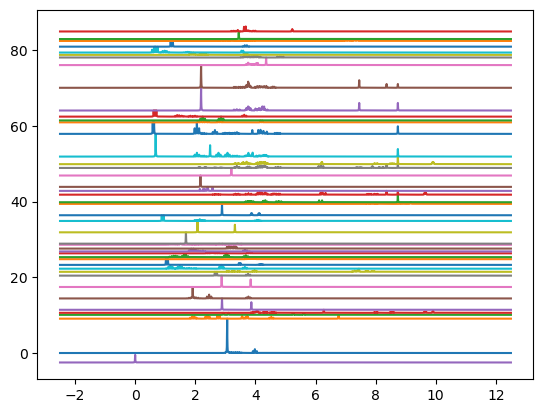

In [5]:
n = 0
for i in np.arange(44):
    plt.plot(ppm_all, standardsSpec[i] + n)
    n += standardsSpec[i].max()
plt.plot(ppm_all, v - 2.5)

In [8]:
## Generate training and testing dataset 
## Use linear combinations with physically inspired modifications (line-broadening, noise, baseline shift, and peak shift) 

## Switch to folder where datasets will be saved
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Create some variables to contain spectra/concentrations as they are generated, and set some variables for the data generation function
max_shift = 15
iterations = int(250000/12)
spectrum_length = 46000
num_metabolites = 44
# Create empty 2D arrays to hold the generated spectra and concentrations
spectra = np.zeros([iterations * 12, spectrum_length])
conc = np.zeros([iterations * 12, num_metabolites])


# Set a seed for reproducible data generation
np.random.seed(1)
random.seed(1)


### Now generate examples with uniform distribution
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.uniform(0.005,24)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*0] = xdata
    conc[i + iterations*0] = ydata
    

print('x')
    
## Loop to generate synthetic data with 50% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.uniform(0.005,24)
        ConcDecision = np.random.choice([0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
     # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    
     # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*1] = xdata
    conc[i + iterations*1] = ydata
    
print('x')
    
    
    ## Loop to generate synthetic data with 75% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.uniform(0.005,24)
        ConcDecision = np.random.choice([0,0,0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
     # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*2] = xdata
    conc[i + iterations*2] = ydata
    
print('x')
    
    
    
### Now generate examples with LowConc distribution
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = np.random.uniform(0.005, 0.05, size=100)
    Dist2 = np.random.uniform(0.005, 0.1, size=100)
    Dist3 = np.random.uniform(0.005, 0.2, size=100)
    LowConcDist = np.concatenate((Dist1, Dist2, Dist3))
    
    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(LowConcDist)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
     # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*3] = xdata
    conc[i + iterations*3] = ydata
    
print('x')

    
## Loop to generate synthetic data with 50% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []
    
    Dist1 = np.random.uniform(0.005, 0.05, size=100)
    Dist2 = np.random.uniform(0.005, 0.1, size=100)
    Dist3 = np.random.uniform(0.005, 0.2, size=100)
    LowConcDist = np.concatenate((Dist1, Dist2, Dist3))

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(LowConcDist)
        ConcDecision = np.random.choice([0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
     # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    
     # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*4] = xdata
    conc[i + iterations*4] = ydata 
    
print('x')
   
    
## Loop to generate synthetic data with 75% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []
    
    Dist1 = np.random.uniform(0.005, 0.05, size=100)
    Dist2 = np.random.uniform(0.005, 0.1, size=100)
    Dist3 = np.random.uniform(0.005, 0.2, size=100)
    LowConcDist = np.concatenate((Dist1, Dist2, Dist3))

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(LowConcDist)
        ConcDecision = np.random.choice([0,0,0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*5] = xdata
    conc[i + iterations*5] = ydata
    
print('x')
  
    
    
    
    
    
### Now generate examples with MimicTissueRange distribution
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = (2/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for iiiii in np.arange(100):
        if Dist1[iiiii] < 0.005:
            Dist1[iiiii] += np.random.uniform(0.005,0.01)
        if Dist1[iiiii] > 24:
            Dist1[iiiii] = np.random.uniform(0.005,1)
    Dist2 = (1/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for iiiii in np.arange(100):
        if Dist2[iiiii] < 0.005:
            Dist2[iiiii] += np.random.uniform(0.005,0.01)
        if Dist2[iiiii] > 24:
            Dist2[iiiii] = np.random.uniform(0.005,1)   
    MimicTissueRange = np.concatenate((Dist1, Dist2)) # Loop to generate concentration representative example spectra
    
    
    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(MimicTissueRange)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*6] = xdata
    conc[i + iterations*6] = ydata
print('x')


## Loop to generate synthetic data with 50% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = (2/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for iiiii in np.arange(100):
        if Dist1[iiiii] < 0.005:
            Dist1[iiiii] += np.random.uniform(0.005,0.01)
        if Dist1[iiiii] > 24:
            Dist1[iiiii] = np.random.uniform(0.005,1)
    Dist2 = (1/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for iiiii in np.arange(100):
        if Dist2[iiiii] < 0.005:
            Dist2[iiiii] += np.random.uniform(0.005,0.01)
        if Dist2[iiiii] > 24:
            Dist2[iiiii] = np.random.uniform(0.005,1)   
    MimicTissueRange = np.concatenate((Dist1, Dist2)) # Loop to generate concentration representative example spectra
    

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(MimicTissueRange)
        ConcDecision = np.random.choice([0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
     # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
     # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*7] = xdata
    conc[i + iterations*7] = ydata
    
print('x')
   
    
## Loop to generate synthetic data with 75% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = (2/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for iiiii in np.arange(100):
        if Dist1[iiiii] < 0.005:
            Dist1[iiiii] += np.random.uniform(0.005,0.01)
        if Dist1[iiiii] > 24:
            Dist1[iiiii] = np.random.uniform(0.005,1)
    Dist2 = (1/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for iiiii in np.arange(100):
        if Dist2[iiiii] < 0.005:
            Dist2[iiiii] += np.random.uniform(0.005,0.01)
        if Dist2[iiiii] > 24:
            Dist2[iiiii] = np.random.uniform(0.005,1)   
    MimicTissueRange = np.concatenate((Dist1, Dist2)) # Loop to generate concentration representative example spectra
    

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(MimicTissueRange)
        ConcDecision = np.random.choice([0,0,0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
  # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
     # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*8] = xdata
    conc[i + iterations*8] = ydata
    
    
print('x')
    
    
    
    
    
    
### Now generate examples with HighDynamicRange2 distribution
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = 0.4*np.random.gamma(0.5, 0.6, size=100)
    Dist2 = 24 - np.random.gamma(1.75, 4, size=40)
    Dist3 = np.random.uniform(0 ,0.02, size=10)
    # Several loops for maintaining the target concentration range
    for iiiiii in np.arange(100):
        if Dist1[iiiiii] < 0:
            Dist1[iiiiii] = abs(Dist1[iiiiii])
    for iiiiii in np.arange(40):
        if Dist2[iiiiii] < 0:
            Dist2[iiiiii] = abs(Dist2[iiiiii])
    for iiiiii in np.arange(100):
        if Dist1[iiiiii] > 24:
            Dist1[iiiiii] = 24
    for iiiiii in np.arange(40):
        if Dist2[iiiiii] > 24:
            Dist2[iiiiii] = 24
    HighDynRange2 = np.concatenate((Dist1, Dist2, Dist3))
    for iiiiii in np.arange(150):
        HighDynRange2[iiiiii] += np.random.choice([np.random.uniform(0.005,0.01),np.random.uniform(0.005,0.05),np.random.uniform(0.005,0.01)])

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(HighDynRange2)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
   # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*9] = xdata
    conc[i + iterations*9] = ydata
 
print('x')


## Loop to generate synthetic data with 50% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = 0.4*np.random.gamma(0.5, 0.6, size=100)
    Dist2 = 24 - np.random.gamma(1.75, 4, size=40)
    Dist3 = np.random.uniform(0 ,0.02, size=10)
    # Several loops for maintaining the target concentration range
    for iiiiii in np.arange(100):
        if Dist1[iiiiii] < 0:
            Dist1[iiiiii] = abs(Dist1[iiiiii])
    for iiiiii in np.arange(40):
        if Dist2[iiiiii] < 0:
            Dist2[iiiiii] = abs(Dist2[iiiiii])
    for iiiiii in np.arange(100):
        if Dist1[iiiiii] > 24:
            Dist1[iiiiii] = 24
    for iiiiii in np.arange(40):
        if Dist2[iiiiii] > 24:
            Dist2[iiiiii] = 24
    HighDynRange2 = np.concatenate((Dist1, Dist2, Dist3))
    for iiiiii in np.arange(150):
        HighDynRange2[iiiiii] += np.random.choice([np.random.uniform(0.005,0.01),np.random.uniform(0.005,0.05),np.random.uniform(0.005,0.01)])


    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(HighDynRange2)
        ConcDecision = np.random.choice([0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*10] = xdata
    conc[i + iterations*10] = ydata     
        
print('x')
        
  
## Loop to generate synthetic data with 75% chance to leave out out any metabolite
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = 0.4*np.random.gamma(0.5, 0.6, size=100)
    Dist2 = 24 - np.random.gamma(1.75, 4, size=40)
    Dist3 = np.random.uniform(0 ,0.02, size=10)
    # Several loops for maintaining the target concentration range
    for iiiiii in np.arange(100):
        if Dist1[iiiiii] < 0:
            Dist1[iiiiii] = abs(Dist1[iiiiii])
    for iiiiii in np.arange(40):
        if Dist2[iiiiii] < 0:
            Dist2[iiiiii] = abs(Dist2[iiiiii])
    for iiiiii in np.arange(100):
        if Dist1[iiiiii] > 24:
            Dist1[iiiiii] = 24
    for iiiiii in np.arange(40):
        if Dist2[iiiiii] > 24:
            Dist2[iiiiii] = 24
    HighDynRange2 = np.concatenate((Dist1, Dist2, Dist3))
    for iiiiii in np.arange(150):
        HighDynRange2[iiiiii] += np.random.choice([np.random.uniform(0.005,0.01),np.random.uniform(0.005,0.05),np.random.uniform(0.005,0.01)])


    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(HighDynRange2)
        ConcDecision = np.random.choice([0,0,0,1])
        scaled = Concentration*ConcDecision*shifted #scale the peak shifted spectra
        c = Concentration*ConcDecision  #define concentration
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(c)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise, size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for iii in np.arange(30):
        InterferenceRange[iii] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for iiii in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to overall arrays
    spectra[i + iterations*11] = xdata
    conc[i + iterations*11] = ydata      

print('x')

        
## Determine max values and scale all spectra
OvMaxL = []
for i in spectra:
    OvMaxL.append(np.max(i))
OvMax = np.max(OvMaxL)
print(OvMax)


del OvMaxL
del InterferenceRange
del HighDynRange2
del MimicTissueRange
del LowConcDist


'''
## Now scale in data in chunks
# Define chunk size
chunk_size = 10000
# Process array in chunks
for start in range(0, 249996, chunk_size):
    end = min(start + chunk_size, 249996)
    spectra[start:end] = spectra[start:end] / OvMax
spectra = spectra/OvMax




## Now save in data in chunks using a  numpy memory map
# Define the filename
filename = 'Dataset44_250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.dat'
# Create a memmap file to save the array in chunks
shape = (249996, 46000)  
dtype = np.float64   
# Create a memmap file to save the array in chunks
# Create a new memmap array
memmap_spectra = np.memmap(filename, dtype=dtype, mode='w+', shape=shape)
# Write the data to the memmap array in chunks
for start in range(0, shape[0], chunk_size):
    end = min(start + chunk_size, shape[0])
    memmap_spectra[start:end] = spectra[start:end]
    memmap_spectra.flush()  # Ensure data is written to disk

    
    

# Save the max value seen in training/testing datasets and the concentrations
np.save("OvMax_Dataset44_250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution.npy", OvMax)
np.save('Dataset44_250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', conc)
'''

#np.save("OvMax_Dataset44_250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution.npy", OvMax)
np.save('Dataset44_250000spec_100MHz_AdjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', conc)
#np.save('Dataset44_250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', spectra)

x
x
x
x
x
x
x
x
x
x
x
x
288.95539978205926


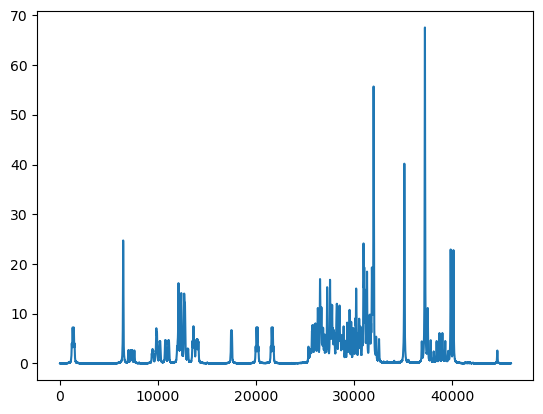

In [9]:
plt.plot(spectra[200009])

In [10]:
# Define chunk size
chunk_size = 10000

# Process array in chunks
for start in range(0, 249996, chunk_size):
    end = min(start + chunk_size, 249996)
    spectra[start:end] = spectra[start:end] / OvMax

In [11]:
np.save('Dataset44_250000spec_100MHz_AdjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', conc)

In [12]:
# Define the chunk size
chunk_size = 10000
filename = 'Dataset44_250000spec_100MHz_AdjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.dat'

# Create a memmap file to save the array in chunks
shape = (249996, 46000)  
dtype = np.float64   

# Create a memmap file to save the array in chunks
# Create a new memmap array
memmap_spectra = np.memmap(filename, dtype=dtype, mode='w+', shape=shape)

# Write the data to the memmap array in chunks
for start in range(0, shape[0], chunk_size):
    end = min(start + chunk_size, shape[0])
    memmap_spectra[start:end] = spectra[start:end]
    memmap_spectra.flush()  # Ensure data is written to disk

# Save the max value seen in training/testing datasets
np.save("OvMax_Dataset44_250000spec_100MHz_AdjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution.npy", OvMax)

In [13]:
type(spectra[0][0])

numpy.float64

In [14]:
len(spectra)

249996

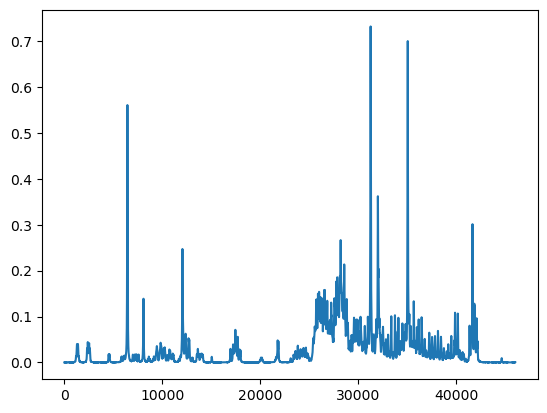

In [15]:
plt.plot(spectra[0])

In [16]:
## A few parameters to report with data generation protocol

BaseShiftMax = 0.15
NoiseAmplitudeMaxSD = 0.025
MaxDMSO2Amplitude = 0.3*(9/2)*v.max()

BaseShiftPercent = 100 * (BaseShiftMax / MaxDMSO2Amplitude)
NoiseAmplitudeSDPercent = 100 * (NoiseAmplitudeMaxSD / MaxDMSO2Amplitude)

print(BaseShiftPercent)
print(NoiseAmplitudeSDPercent)

5.557008713334093
0.9261681188890156


In [17]:
## Generate validation dataset 
## Use linear combinations with physically inspired modifications (line-broadening, noise, baseline shift, and peak shift) 

## Switch to folder where datasets will be saved
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Create some empty lists to contain spectra/concentrations as they are generated, and set some variables for the data generation function
spectra = []
conc = []
max_shift = 15
iterations = int(5000/4)

# Set a seed for reproducible data generation
np.random.seed(2)


### Now generate examples with uniform distribution
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.uniform(0.005,24)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for i in np.arange(30):
        InterferenceRange[i] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for i in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to list
    spectra.append(xdata)
    conc.append(ydata) 
    
    

    
### Now generate examples with LowConc distribution
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = np.random.uniform(0.005, 0.05, size=100)
    Dist2 = np.random.uniform(0.005, 0.1, size=100)
    Dist3 = np.random.uniform(0.005, 0.2, size=100)
    LowConcDist = np.concatenate((Dist1, Dist2, Dist3))
    
    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(LowConcDist)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for i in np.arange(30):
        InterferenceRange[i] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for i in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to list
    spectra.append(xdata)
    conc.append(ydata) 
    
    
    
    
    
### Now generate examples with MimicTissueRange distribution
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    # Generate the distribution (generate more examples) With some loops for maintaining desired concentration limits
    Dist1 = (2/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for i in np.arange(100):
        if Dist1[i] < 0.005:
            Dist1[i] += np.random.uniform(0.005,0.01)
        if Dist1[i] > 24:
            Dist1[i] = np.random.uniform(0.005,1)
    Dist2 = (1/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 100)
    for i in np.arange(100):
        if Dist2[i] < 0.005:
            Dist2[i] += np.random.uniform(0.005,0.01)
        if Dist2[i] > 24:
            Dist2[i] = np.random.uniform(0.005,1)   
    MimicTissueRange = np.concatenate((Dist1, Dist2)) # Loop to generate concentration representative example spectra
    
    
    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(MimicTissueRange)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for i in np.arange(30):
        InterferenceRange[i] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    
    # Randomly add three singlet signals
    for i in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    # Append spectrum and metabolite profile variables to list
    spectra.append(xdata)
    conc.append(ydata) 
    
    
    
    
    
### Now with HighDynamicRange2 distribution     
## Loop to generate synthetic data without leaving out any metabolites
for i in range(iterations):
    xdata = []
    ydata = []
    
    Dist1 = 0.4*np.random.gamma(0.5, 0.6, size=100)
    Dist2 = 24 - np.random.gamma(1.75, 4, size=40)
    Dist3 = np.random.uniform(0 ,0.02, size=10)
    # Several loops for maintaining the target concentration range
    for i in np.arange(100):
        if Dist1[i] < 0:
            Dist1[i] = abs(Dist1[i])
    for i in np.arange(40):
        if Dist2[i] < 0:
            Dist2[i] = abs(Dist2[i])
    for i in np.arange(100):
        if Dist1[i] > 24:
            Dist1[i] = 24
    for i in np.arange(40):
        if Dist2[i] > 24:
            Dist2[i] = 24
    HighDynRange2 = np.concatenate((Dist1, Dist2, Dist3))
    for i in np.arange(150):
        HighDynRange2[i] += np.random.choice([np.random.uniform(0.005,0.01),np.random.uniform(0.005,0.05),np.random.uniform(0.005,0.01)])

    # Loop through and scale each standard, potentially leaving each out. Do the same for metabolite concentrations. Combine all spectra and metabolite profiles into separate lists. 
    # Sum all spectra into one synthetic mixture and add maleic acid as reference. Create random seeds and random variables throughout.
    for ii in np.arange(44):
        ShiftDirection = np.random.uniform(-1,1) 
        shifted = ng.process.proc_base.cs(standardsSpec[ii],np.random.choice([0,ShiftDirection*max_shift]))  #shift peaks
        Concentration = np.random.choice(HighDynRange2)
        scaled = Concentration*shifted #scale the peak shifted spectra
        xdata.append(scaled)  #add all shifted, scaled spectra to list
        ydata.append(Concentration)  #add all concentrations to list
    xdata = np.array(xdata).sum(axis=0) + v*0.3*(9/2)  #sum all 10 metabolite spectra and add psuedo-TSP-d4 as reference
    ydata = np.array(ydata)
    
    # Inverse FFT (real-valued), apply line-broadening, and FFT (real-valued)
    linebroad = np.random.uniform(0,1)
    xdata = ng.proc_base.irft(xdata)
    xdata = exponential_apodization(xdata, linebroad)
    xdata = ng.proc_base.rft(xdata)
    
    # Select signal region and add random noise
    noise = 8*np.random.uniform(0.3,1.15)*0.003975
    xdata = xdata[10000:56000]+np.random.normal(0, noise,size = 46000)
    
    # Shift baseline up or down
    xdata = xdata + np.random.uniform(-0.1,0.1)
    
    
    # Define the intensity distribution for interfering singlets
    InterferenceRange = 150*np.random.gamma(0.2, 0.02, size = 30)
    for i in np.arange(30):
        InterferenceRange[i] += np.random.uniform(0.005, 0.5) + np.random.choice([0, np.random.uniform(0.005, 0.02)])
    for i in np.arange(3):
        Intensity = np.random.choice(InterferenceRange)
        Sig1 = Singlet*Intensity
        Sig1 = random.choice([np.zeros(2995),Sig1])
        Placement = random.choice(np.arange(46000-2995))
        xdata[Placement:Placement+2995] = xdata[Placement:Placement+2995] + Sig1
    
    
    # Append spectrum and metabolite profile variables to list
    spectra.append(xdata)
    conc.append(ydata) 


spectra = spectra/OvMax


# Save the arrays to files, and save max value seen in training/testing datasets
np.save('Dataset44_250000spec_100MHz_AdjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Val_Spec.npy', spectra)
np.save('Dataset44_250000spec_100MHz_AdjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Val_Conc.npy', conc)

#### Now generate some representative input spectra with up to 44 metabolites

In [18]:
OvMax = 288.95539978205926

In [19]:
## Function for pre-processing generated or simulated spectra for input into the MLP
def spec_proc(spectrum):
    spectrum = np.reshape(spectrum,[1,65536])+8*np.random.normal(0, 0.003975,65536)
    spectrum = spectrum[:,10000:56000]/OvMax
    return spectrum

In [20]:
# Switch to folder where datasets will be saved
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

## Create validation examples

# Set some random seeds for reproducibility
np.random.seed(100)
random.seed(100)

# Create variable with the 44 trained metabolites and reformat/pre-process for neural network training
Concentrations = [0, 0.005, 0.025, 0.1, 0.25, 0.5, 1, 2.5, 10, 20] # Define concentrations
ConcSpec = []  # List for containing generated spectra
ConcConc = []  # List for containing generated concentrations
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    spec = 0.3*(9/2)*v + Concentrations[i]*standardsSpec.sum(axis=0)
    ConcSpec.append(spec_proc(spec))    
    ConcConc.append(np.zeros(44)+Concentrations[i])    
# Save variables
np.save('Concentration_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', ConcSpec)
np.save('Concentration_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', ConcConc)    


# Create 10 variables with 44 metabolites with concentrations pulled from a uniform distribution 
UniformSpec = []  # List for containing generated spectra
UniformConc = []  # List for containing generated concentrations
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    UniformDist = np.random.uniform(0.005, 20, size=44)  # Pull 44 numbers from the uniform concentration distribution
    PreConc2 = [] # Intermediate list for containting each examples concentrations
    spec = np.zeros(65536)  # Prepare empty spectra for adding metabolite spectra to
    for ii in np.arange(44):
        PreSpec = UniformDist[ii]*standardsSpec[ii]
        PreConc1 = UniformDist[ii]
        spec += PreSpec
        PreConc2.append(PreConc1)  
    spec += 0.3*(9/2)*v   # Add the quantitative reference
    UniformSpec.append(spec_proc(spec))
    UniformConc.append(PreConc2)
# Save variables
np.save('UniformDist_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', UniformSpec)
np.save('UniformDist_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', UniformConc)  
    
    
    
# Create 10 variables with 44 metabolites with concentrations pulled from a low concentration uniform distribution 
LowUniformSpec = []  # List for containing generated spectra
LowUniformConc = []  # List for containing generated concentrations
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    UniformDist = np.random.uniform(0.005, 0.25, size=44)  # Pull 44 numbers from the uniform concentration distribution
    PreConc2 = [] # Intermediate list for containting each examples concentrations
    spec = np.zeros(65536)  # Prepare empty spectra for adding metabolite spectra to
    for ii in np.arange(44):
        PreSpec =  UniformDist[ii]*standardsSpec[ii]
        PreConc1 = UniformDist[ii]
        spec += PreSpec
        PreConc2.append(PreConc1)   
    spec += 0.3*(9/2)*v
    LowUniformSpec.append(spec_proc(spec))
    LowUniformConc.append(PreConc2)
# Save variables
np.save('LowUniformDist_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', LowUniformSpec)
np.save('LowUniformDist_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', LowUniformConc)



# Create 10 variables with 44 metabolites with concentrations pulled from a tissue mimicking concentration distribution 
MimicTissueRangeSpec = []  # List for containing generated spectra
MimicTissueRangeConc = []  # List for containing generated concentrations
# Generate the distribution (generate examples) With some loops for maintaining desired concentration limits
Dist1 = (2/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 2500)
for i in np.arange(2500):
    if Dist1[i] < 0.005:
        Dist1[i] += np.random.uniform(0.005,0.01)
    if Dist1[i] > 20:
        Dist1[i] = np.random.uniform(0.005,1)
Dist2 = (1/5)*np.random.lognormal(mean = 0, sigma = 1.5, size = 2500)
for i in np.arange(2500):
    if Dist2[i] < 0.005:
        Dist2[i] += np.random.uniform(0.005,0.01)
    if Dist2[i] > 20:
        Dist2[i] = np.random.uniform(0.005,1)   
MimicTissueRange = np.concatenate((Dist1, Dist2)) # Loop to generate concentration representative example spectra
for i in np.arange(10):
    PreConc2 = [] # Intermediate list for containting each examples concentrations
    spec = np.zeros(65536)  # Prepare empty spectra for adding metabolite spectra to
    for ii in np.arange(44):
        MultiTissueDist = np.random.choice(MimicTissueRange)  # Pull 1 number from the multi tissue concentration distribution
        PreSpec =  MultiTissueDist*standardsSpec[ii]
        PreConc1 = MultiTissueDist
        spec += PreSpec
        PreConc2.append(PreConc1)  
    spec += 0.3*(9/2)*v   # Add the quantitative reference
    MimicTissueRangeSpec.append(spec_proc(spec))
    MimicTissueRangeConc.append(PreConc2)
# Save variables
np.save('MimicTissueRange_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', MimicTissueRangeSpec)
np.save('MimicTissueRange_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', MimicTissueRangeConc)

    

# Create 10 variables with 44 metabolites with concentrations pulled from a tissue mimicking concentration distribution, similar to liver and some other tissues with glucose in high relative concentration 
MimicTissueRangeGlucSpec = []  # List for containing generated spectra
MimicTissueRangeGlucConc = []  # List for containing generated concentrations
# Generate the distribution (generate examples)
Dist1 = 150*np.random.gamma(0.2, 0.02, size = 1000)
Dist2 = 100*np.random.gamma(0.15, 0.02, size = 1000)+abs(np.random.normal(0.25,0.1))
# A few loops to ensure no negatives and no values higher than 20 mM
for i in np.arange(1000):
    if Dist1[i] < 0:
        Dist1[i] = abs(Dist1[i])
for i in np.arange(1000):
    if Dist2[i] < 0:
        Dist2[i] = abs(Dist2[i])
for i in np.arange(1000):
    if Dist1[i] > 20:
        Dist1[i] = 20
for i in np.arange(1000):
    if Dist2[i] > 20:
        Dist2[i] = 20
GlucDist = np.random.uniform(0.1, 20, size = 150)
MimicTissueRange = np.concatenate((Dist1, Dist2)) + np.random.choice([0.005,np.random.uniform(0.005,0.025),np.random.uniform(0.005,0.025),np.random.uniform(0.01,0.04),np.random.uniform(0.01,0.05)])
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    PreConc2 = [] # Intermediate list for containting each examples concentrations
    spec = np.zeros(65536)  # Prepare empty spectra for adding metabolite spectra to
    for ii in np.arange(43):
        MultiTissueDist = np.random.choice(MimicTissueRange)  # Pull 1 numbers from the multi tissue concentration distribution
        PreSpec = MultiTissueDist*standardsSpec[ii]
        PreConc1 = MultiTissueDist
        spec += PreSpec
        PreConc2.append(PreConc1)  
    GlucConc = np.random.choice(GlucDist)
    GlucSpec = standardsSpec[-1]*GlucConc
    spec += GlucSpec + 0.3*(9/2)*v   # Add the quantitative reference & the glucose spectrum
    PreConc2.append(GlucConc)
    MimicTissueRangeGlucSpec.append(spec_proc(spec))
    MimicTissueRangeGlucConc.append(PreConc2)
# Save variables
np.save('MimicTissueRangeGluc_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', MimicTissueRangeGlucSpec)
np.save('MimicTissueRangeGluc_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', MimicTissueRangeGlucConc)

    
# Create 10 variables with 44 metabolites with concentrations from a further high dynamic range distribution 
HighDynamicRange2Spec = []  # List for containing generated spectra
HighDynamicRange2Conc = []  # List for containing generated concentrations
# Generate the distribution (generate examples)
Dist1 = 0.4*np.random.gamma(0.5, 0.6, size=2500)
Dist2 = 20 - np.random.gamma(1.75, 4, size=4000)
Dist3 = np.random.uniform(0 ,0.02, size=1000)
# Several loops for maintaining the target concentration range
for i in np.arange(2500):
    if Dist1[i] < 0:
        Dist1[i] = abs(Dist1[i])
for i in np.arange(4000):
    if Dist2[i] < 0:
        Dist2[i] = abs(Dist2[i])
for i in np.arange(2500):
    if Dist1[i] > 20:
        Dist1[i] = 20
for i in np.arange(4000):
    if Dist2[i] > 20:
        Dist2[i] = 20
HighDynRange2 = np.concatenate((Dist1, Dist2, Dist3))
for i in np.arange(7500):
    HighDynRange2[i] += np.random.choice([np.random.uniform(0.005,0.01),np.random.uniform(0.005,0.05),np.random.uniform(0.005,0.01)])
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    PreConc = [] # Intermediate list for containting each examples concentrations
    spec = np.zeros(65536)  # Prepare empty spectra for adding metabolite spectra to
    for ii in np.arange(44):
        HighDynRange2Dist = np.random.choice(HighDynRange2)  # Pull 1 numbers from the multi tissue concentration distribution
        PreSpec = HighDynRange2Dist*standardsSpec[ii]
        spec += PreSpec
        PreConc.append(HighDynRange2Dist)  # define the concentration
    spec += 0.3*(9/2)*v   # Add the quantitative reference & the glucose spectrum
    HighDynamicRange2Spec.append(spec_proc(spec))
    HighDynamicRange2Conc.append(PreConc)
# Save variables
np.save('HighDynRange2_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', HighDynamicRange2Spec)
np.save('HighDynRange2_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', HighDynamicRange2Conc)
    
    
    
# Create 10 variables with 44 metabolites (@0.43mM -the mean seen in experimental data) 
SNR_Spec = []  # List for containing generated spectra
SNR_Conc = np.zeros(44) + 0.43
ScaleNoise = (1/2)*(np.arange(10)+1)
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    spec = 0.3*(9/2)*v + 0.43*standardsSpec.sum(axis=0)
    spec = np.reshape(spec,[1,65536])+ScaleNoise[i]*np.random.normal(0, 0.003975,65536)
    spec = spec[:,2500:56000]/OvMax
    SNR_Spec.append(spec)
# Save variables
np.save('SNR_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', SNR_Spec)
np.save('SNR_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', SNR_Conc)



# Create 10 variables with 44 metabolites (@0.43mM -the mean seen in experimental data) with varied number of randomly added singlets
# Load spectrum used for singlet
os.chdir(base_dir+"/DL-NMR-Optimization/HMDBSpectraFiles/87Met")  # Switch to appropriate folders and load data
vXd, vX = ng.jcampdx.read('HMDB0000042_5433_predicted_H_400.jdx')  # acetic acid, for adding random singlets
Singlet = vX[vX != 0]  # make variable of acetic acid without zeros
# Switch to folder where datasets will be saved
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')
# Instantiate some variables
Singlet_Spec = []  # List for containing generated spectra
Singlet_Conc = np.zeros(44) + 0.43
SingletNumber = [0, 1, 2, 3, 5, 7, 10, 15, 20, 30]
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    np.random.seed(50) # set seed for reproducible singlet placement between examples
    spec = 0.3*(9/2)*v + 0.43*standardsSpec.sum(axis=0)
    spec = spec_proc(spec)
    # Add Singlets randomly
    for ii in np.arange(SingletNumber[i]):
        Intensity = 0.43
        Sig = Singlet*Intensity
        Placement = np.random.choice(np.arange(46000-2995))
        spec[0][Placement:Placement+2995] = spec[0][Placement:Placement+2995] + Sig/OvMax
    Singlet_Spec.append(spec)
# Save variables
np.save('Singlet_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', Singlet_Spec)
np.save('Singlet_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', Singlet_Conc)



# Create 10 variables with 44 metabolites (@0.43mM -the mean seen in experimental data)
# Instantiate some variables
QrefSensSpec = []  # List for containing generated spectra
QrefSensConc = np.zeros(44) + 0.43
ScaleRef = (1/2)*(np.arange(10)+1)
# Loop to generate concentration representative example spectra
for i in np.arange(10):
    spec = ScaleRef[i]*(9/2)*v + 0.43*standardsSpec.sum(axis=0)
    spec = spec_proc(spec) 
    QrefSensSpec.append(spec)
# Save variables
np.save('QrefSensitivity_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', QrefSensSpec)
np.save('QrefSensitivity_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', QrefSensConc)








np.random.seed(101)
## Create variable with the 10 trained metabolites (@0.43mM) with sinusoidal baseline
SineBase = 0.3*(9/2)*v  +0.43*standardsSpec.sum(axis=0)
SineBase = spec_proc(SineBase)
time = np.arange(0, 46000, 1) # Setting up time vector for creating sinusoid
amplitude = 0.0002*np.sin(time*0.00025) # defining sinusoid parameters
SineBase = amplitude+SineBase
SineBase_c = np.zeros(44)+0.43


## Create variable with the 10 trained metabolites (@0.43mM) with another sinusoidal baseline
SineBase2 = 0.3*(9/2)*v  +0.43*standardsSpec.sum(axis=0)
SineBase2 = spec_proc(SineBase2)
time = np.arange(0, 46000, 1) # Setting up time vector for creating sinusoid
amplitude = 0.0003*np.sin(time*0.00055) # defining sinusoid parameters
SineBase2 = amplitude+SineBase2
SineBase2_c = np.zeros(44)+0.43


# Create variable with the 44 trained metabolites alternating between 0.005 and 20 mM (high dynamic range signal)
x = 44  # Number of metabolites
AllAq_HD_c = np.tile([0.01, 20], x // 2 + 1)[:x]
AllAq_HD = 0.3*(9/2)*v + AllAq_HD_c[:, np.newaxis]*standardsSpec
AllAq_HD = spec_proc(AllAq_HD.sum(axis=0))


# Create variable with the 8 trained metabolites alternating between 0 and 20 mM (see how zero is handled)
x = 44  # Number of metabolites
AllAq_HalfZero_c = np.tile([0, 20], x // 2 + 1)[:x]
AllAq_HalfZero = 0.3*(9/2)*v + AllAq_HalfZero_c[:, np.newaxis]*standardsSpec
AllAq_HalfZero = spec_proc(AllAq_HalfZero.sum(axis=0))



# Switch to folder where datasets will be saved
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')
# Make array of all spectra and all concentrations, and make list with variable names
OtherValSpectra = np.array([SineBase, SineBase2, AllAq_HD, AllAq_HalfZero])
OtherValConc = np.array([SineBase_c, SineBase2_c,AllAq_HD_c, AllAq_HalfZero_c])
# Save variables
np.save('OtherVal_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Spec.npy', OtherValSpectra)
np.save('OtherVal_44met_250000spec_100MHz_AjustSNR_ExtendedRange_MoreLeftOut_Combined1Distribution_ForManuscript_Conc.npy', OtherValConc)